# RGB images 650x650

C:\Users\HP\AppData\Local\Temp\ipykernel_21228\2370932654.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


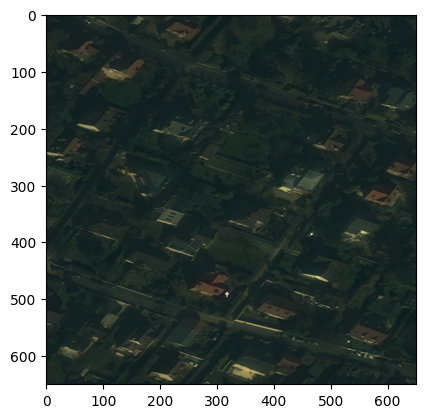

In [6]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
image_path = "RGB-PanSharpen\RGB-PanSharpen_AOI_3_Paris_img278.tif"
image = imageio.imread(image_path)

def normalize_array(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    normalized_array = 255 * ((array - min_val) / (max_val - min_val))
    return normalized_array.astype(np.uint8)

image_scaled = normalize_array(image)
plt.imshow(image_scaled)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


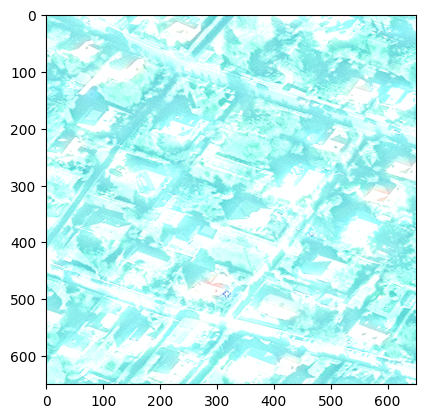

In [7]:
plt.imshow(image)

plt.show()

# Applying Mask with geojson coordinates on RGB image

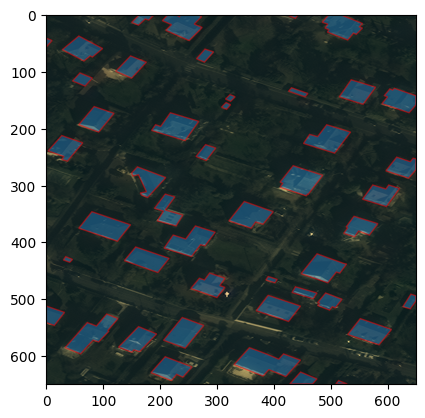

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from rasterio.plot import show

def normalize_array(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    normalized_array = 255 * ((array - min_val) / (max_val - min_val))
    return normalized_array.astype(np.uint8)



def geojson_to_pixel_arr(image_path, geojson_file, pixel_ints=True, verbose=False):
    with rasterio.open(image_path) as src:
        # Get the raster's coordinate reference system
        targetsr = src.crs

        # Get the geometric transformation
        geom_transform = src.transform

        # Load the GeoJSON file
        with open(geojson_file) as f:
            geojson_data = json.load(f)

        # Extract the coordinates and geometry types from the GeoJSON features
        latlons = []
        types = []
        for feature in geojson_data['features']:
            coords_tmp = feature['geometry']['coordinates'][0]
            type_tmp = feature['geometry']['type']
            latlons.append(coords_tmp)
            types.append(type_tmp)

        # Convert lat-lon coordinates to pixel coordinates
        pixel_coords = []
        latlon_coords = []
        for i, (poly_type, poly0) in enumerate(zip(types, latlons)):
            if poly_type.upper() == 'MULTIPOLYGON':
                for poly in poly0:
                    poly = np.array(poly)
                    poly_list_pix = []
                    poly_list_latlon = []
                    for coord in poly:
                        lon, lat, _ = coord
                        row, col = src.index(lon, lat)
                        poly_list_pix.append([col, row])
                        poly_list_latlon.append([lat, lon])

                    if pixel_ints:
                        ptmp = np.rint(poly_list_pix).astype(int)
                    else:
                        ptmp = poly_list_pix
                    pixel_coords.append(ptmp)
                    latlon_coords.append(poly_list_latlon)

            elif poly_type.upper() == 'POLYGON':
                poly = np.array(poly0)
                poly_list_pix = []
                poly_list_latlon = []
                for coord in poly:
                    lon, lat, _ = coord
                    row, col = src.index(lon, lat)
                    poly_list_pix.append([col, row])
                    poly_list_latlon.append([lat, lon])

                if pixel_ints:
                    ptmp = np.rint(poly_list_pix).astype(int)
                else:
                    ptmp = poly_list_pix
                pixel_coords.append(ptmp)
                latlon_coords.append(poly_list_latlon)

            else:
                print("Unknown shape type in coords_arr_from_geojson()")
                return

        return pixel_coords, latlon_coords

# plot the image with  footprints
def plot_image_with_footprints(image_path, pixel_coords):
    
    # read image
    with rasterio.open(image_path) as src:
        image = src.read()
        image= normalize_array(image)

    fig, ax = plt.subplots()

    # show the image
    show(image, ax=ax)

    # add polygons to the ax
    for coords in pixel_coords:
        polygon = patches.Polygon(coords, fill=True, edgecolor='red', alpha=0.5)
        ax.add_patch(polygon)

    # Show polygons+input image
    plt.show()


image_path = "RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img278.tif"
geojson_path = "geojson/buildings/buildings_AOI_3_Paris_img278.geojson"


pixel_coords, _ = geojson_to_pixel_arr(image_path, geojson_path)


plot_image_with_footprints(image_path, pixel_coords)


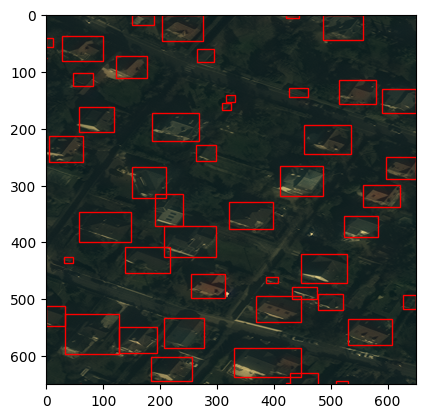

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from rasterio.plot import show

# Define a function to parse YOLO format and convert to pixel coordinates
def yolo_to_pixel_coords(yolo_coords, image_width, image_height):
    x_center, y_center, bbox_width, bbox_height = yolo_coords
    x_min = (x_center - bbox_width / 2) * image_width
    x_max = (x_center + bbox_width / 2) * image_width
    y_min = (y_center - bbox_height / 2) * image_height
    y_max = (y_center + bbox_height / 2) * image_height
    return [x_min, y_min, x_max, y_max]

# Read YOLO format file (replace with your YOLO file)
yolo_file_path = r"dataset_YOLO\BBox_coordinates_YOLO\AOI_3_Paris_img278.txt"

# Read image (replace with your image path)
image_path = "RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img278.tif"
with rasterio.open(image_path) as src:
    image = src.read()
    image = normalize_array(image)
    image_width, image_height = src.width, src.height

# Parse YOLO format and convert to pixel coordinates
pixel_coords = []
with open(yolo_file_path, 'r') as yolo_file:
    for line in yolo_file:
        yolo_data = line.strip().split()
        class_id = int(yolo_data[0])
        yolo_coords = [float(coord) for coord in yolo_data[1:]]
        pixel_bbox = yolo_to_pixel_coords(yolo_coords, image_width, image_height)
        pixel_coords.append(pixel_bbox)

# Plot the image with bounding box masks
fig, ax = plt.subplots()
show(image, ax=ax)

for bbox in pixel_coords:
    x_min, y_min, x_max, y_max = bbox
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.show()


# Create bbox files from my df of polygons coordinates YOLO format

In [11]:
import os
import pandas as pd

def convert_polygon_to_bounding_boxes(polygon_wkt_pix, img_width, img_height):
    # Replace 'EMPT' with an empty string
    polygon_wkt_pix = polygon_wkt_pix.replace('EMPT', '').strip()

    # Assuming the polygon format is a WKT Polygon string with pixel coordinates
    if not polygon_wkt_pix or 'POLYGON ((' not in polygon_wkt_pix:
        # Return an empty list if the polygon is empty or invalid
        return []

    polygons = polygon_wkt_pix.split('),(')
    bounding_boxes = []
    
    for polygon in polygons:
        polygon_list = polygon.strip('POLYGON ((').strip('))').split(',')
        x_coords = [float(point.split()[0]) for point in polygon_list]
        y_coords = [float(point.split()[1]) for point in polygon_list]

        min_x = min(x_coords)
        max_x = max(x_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)

        # Calculate YOLOv5 format coordinates (normalized)
        x_center = (min_x + max_x) / (2 * img_width)
        y_center = (min_y + max_y) / (2 * img_height)
        width = (max_x - min_x) / img_width
        height = (max_y - min_y) / img_height

        bounding_boxes.append((x_center, y_center, width, height))

    return bounding_boxes

def create_yolo_format_bbox(dataframe, output_folder, img_width, img_height):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    grouped = dataframe.groupby('ImageId')
    for image_id, group in grouped:
        yolo_format = ""

        for _, row in group.iterrows():
            bbox_coords_list = convert_polygon_to_bounding_boxes(row['PolygonWKT_Pix'], img_width, img_height)

            for bbox_coords in bbox_coords_list:
                yolo_format += f"0 {bbox_coords[0]:.6f} {bbox_coords[1]:.6f} {bbox_coords[2]:.6f} {bbox_coords[3]:.6f}\n"

        if yolo_format:
            yolo_file_path = os.path.join(output_folder, f"{image_id}.txt")
            with open(yolo_file_path, 'w') as yolo_file:
                yolo_file.write(yolo_format)

# Replace this DataFrame with your actual data
your_dataframe = pd.read_csv("summaryData/AOI_3_Paris_Train_Building_Solutions.csv")
output_folder = "box"

# Replace 'img_width' and 'img_height' with the actual dimensions of your images
img_width = 650
img_height = 650

create_yolo_format_bbox(your_dataframe, output_folder, img_width, img_height)


# Create bbox files from my df of polygons coordinates pascal VOC format for SSD

In [14]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from shapely.wkt import loads
from shapely.geometry import Polygon

def convert_polygon_to_bounding_boxes(polygon_wkt_pix, img_width, img_height):
    # Replace 'EMPT' with an empty string
    polygon_wkt_pix = polygon_wkt_pix.replace('EMPT', '').strip()

    # Assuming the polygon format is a WKT Polygon string with pixel coordinates
    if not polygon_wkt_pix or 'POLYGON ((' not in polygon_wkt_pix:
        # Return an empty list if the polygon is empty or invalid
        return []

    polygons = polygon_wkt_pix.split('),(')
    bounding_boxes = []
    
    for polygon in polygons:
        polygon_list = polygon.strip('POLYGON ((').strip('))').split(',')
        x_coords = [float(point.split()[0]) for point in polygon_list]
        y_coords = [float(point.split()[1]) for point in polygon_list]

        min_x = min(x_coords)
        max_x = max(x_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)

        # Calculate YOLOv5 format coordinates (normalized)
        x_center = (min_x + max_x) / (2 * img_width)
        y_center = (min_y + max_y) / (2 * img_height)
        width = (max_x - min_x) / img_width
        height = (max_y - min_y) / img_height

        bounding_boxes.append((x_center, y_center, width, height))

    return bounding_boxes

def create_xml_annotation(image_filename, image_width, image_height, class_name, bbox_list):
    root = ET.Element('annotation')
    
    folder = ET.SubElement(root, 'folder')
    folder.text = 'VOC2007'
    
    filename = ET.SubElement(root, 'filename')
    filename.text = image_filename
    
    size = ET.SubElement(root, 'size')
    width = ET.SubElement(size, 'width')
    width.text = str(image_width)
    height = ET.SubElement(size, 'height')
    height.text = str(image_height)
    depth = ET.SubElement(size, 'depth')
    depth.text = '3'
    
    for bbox_coords in bbox_list:
        obj = ET.SubElement(root, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = class_name
        bndbox = ET.SubElement(obj, 'bndbox')
        xmin = ET.SubElement(bndbox, 'xmin')
        ymin = ET.SubElement(bndbox, 'ymin')
        xmax = ET.SubElement(bndbox, 'xmax')
        ymax = ET.SubElement(bndbox, 'ymax')
        
        x_center, y_center, width, height = bbox_coords
        xmin.text = str(int((x_center - width / 2) * image_width))
        ymin.text = str(int((y_center - height / 2) * image_height))
        xmax.text = str(int((x_center + width / 2) * image_width))
        ymax.text = str(int((y_center + height / 2) * image_height))
    
    tree = ET.ElementTree(root)
    return tree

def create_voc_format_bbox(dataframe, output_folder, img_width, img_height):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    grouped = dataframe.groupby('ImageId')
    for image_id, group in grouped:
        bbox_list = []

        for _, row in group.iterrows():
            bbox_coords_list = convert_polygon_to_bounding_boxes(row['PolygonWKT_Pix'], img_width, img_height)
            bbox_list.extend(bbox_coords_list)

        if bbox_list:
            xml_tree = create_xml_annotation(image_id, img_width, img_height, 'building', bbox_list)
            xml_file_path = os.path.join(output_folder, f"{image_id}.xml")
            xml_tree.write(xml_file_path)

# Load your DataFrame
dataframe = pd.read_csv("summaryData/AOI_3_Paris_Train_Building_Solutions.csv")  # Replace with your DataFrame file path
output_folder_voc = r"D:\AOI_3_Paris_Train\dataset_SSD\RGB\full_Dataset\annotations"  # Pascal VOC format annotations

# Replace 'img_width' and 'img_height' with the actual dimensions of your images
img_width = 650
img_height = 650

# Create Pascal VOC format annotations
create_voc_format_bbox(dataframe, output_folder_voc, img_width, img_height)


# Preprocess RGB images in png format

In [16]:
import os
import imageio
import numpy as np

def normalize_array(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    normalized_array = 255 * ((array - min_val) / (max_val - min_val))
    return normalized_array.astype(np.uint8)

# Replace these paths with your input and output folder paths
input_folder = "RGB-PanSharpen"
output_folder = "RGB-Prepro"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get a list of all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(".tif")]

for image_file in image_files:
    input_image_path = os.path.join(input_folder, image_file)

    # Extract the original image filename without the "RGB-PanSharpen_" prefix
    original_filename = image_file.replace("RGB-PanSharpen_", "")
    output_image_path = os.path.join(output_folder, os.path.splitext(original_filename)[0] + ".png")

    image = imageio.imread(input_image_path)

    # Normalize the array and scale it to 8-bit unsigned integers (uint8)
    image_normalized = normalize_array(image)

    # Save the normalized image in PNG format in the output folder
    imageio.imwrite(output_image_path, image_normalized)


C:\Users\HP\AppData\Local\Temp\ipykernel_8764\363349789.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(input_image_path)


# rename MUL images to get the same name of BBOx coordinates 

In [85]:
import os
import shutil

def rename_and_copy_images(source_folder, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(source_folder):
        if filename.startswith("MUL-PanSharpen_"):
            new_filename = filename.replace("MUL-PanSharpen_", "")
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, new_filename)
            shutil.copy(source_path, destination_path)

# Replace these paths with your actual input and output folder paths
source_folder = "D:/AOI_3_Paris_Train/MUL-PanSharpen"
destination_folder = "D:/AOI_3_Paris_Train/MUL-Prepro"

rename_and_copy_images(source_folder, destination_folder)


# Create dataset folder : images(train/test),labels(train/test) / just labeled images 

In [16]:
import os
import random
import shutil

# Set the paths to your folders
images_folder = "D:/AOI_3_Paris_Train/RGB-Prepro"
box_coordinates_folder = r"D:\AOI_3_Paris_Train\dataset_Faster_RCNN\full_Dataset_2"
output_folder = r"D:\AOI_3_Paris_Train\dataset_Faster_RCNN\full_Dataset_FasterRCNN"  

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Create sub-folders within the output folder for images and labels
output_images_folder = os.path.join(output_folder, "images")
output_labels_folder = os.path.join(output_folder, "labels")
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

# Function to copy files to the respective train or test folder
def copy_files(source_folder, destination_folder, files):
    for file in files:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(destination_folder, file)
        shutil.copy(source_path, destination_path)

# Get a list of image and label files
image_files = [file for file in os.listdir(images_folder) if file.endswith(".png")]
label_files = [file for file in os.listdir(box_coordinates_folder) if file.endswith(".json")]

# Remove file extension to get a list of image names without extensions
image_names = [os.path.splitext(file)[0] for file in image_files]
label_names = [os.path.splitext(file)[0] for file in label_files]

# Get the common image and label names
common_names = set(image_names).intersection(label_names)

# Shuffle the common names for randomness
random.seed(42)  # For reproducibility, you can change the seed value if desired
shuffled_common_names = random.sample(common_names, len(common_names))

# Define the proportion of data to be used for training
train_proportion = 0.8

# Calculate the number of samples for training and testing
num_train_samples = int(len(shuffled_common_names) * train_proportion)
num_test_samples = len(shuffled_common_names) - num_train_samples

# Split the common names into train and test sets
train_names = shuffled_common_names[:num_train_samples]
test_names = shuffled_common_names[num_train_samples:]

# Copy images and corresponding labels to train and test folders
train_images_folder = os.path.join(output_images_folder, "train")
test_images_folder = os.path.join(output_images_folder, "test")
train_labels_folder = os.path.join(output_labels_folder, "train")
test_labels_folder = os.path.join(output_labels_folder, "test")

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(test_labels_folder, exist_ok=True)

copy_files(images_folder, train_images_folder, [name + ".png" for name in train_names])
copy_files(images_folder, test_images_folder, [name + ".png" for name in test_names])
copy_files(box_coordinates_folder, train_labels_folder, [name + ".json" for name in train_names])
copy_files(box_coordinates_folder, test_labels_folder, [name + ".json" for name in test_names])

print("Data split and shuffling completed successfully!")


C:\Users\HP\AppData\Local\Temp\ipykernel_3908\3289106691.py:39: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  shuffled_common_names = random.sample(common_names, len(common_names))


Data split and shuffling completed successfully!


# Create dataset folders with same shape of Paris dataset RGB and MUL

In [3]:
import os
import shutil

def copy_files(source_folder, destination_folder, num_files):
    files = os.listdir(source_folder)
    selected_files = files[:num_files]
    for file in selected_files:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(destination_folder, file)
        shutil.copy(source_path, destination_path)

def main():
    # Replace these paths with your actual folder paths
    train_folder = r"D:\SpaceNet Dataset\AOI_2_Vegas_Train\full_MUL_Vegas\images\train"
    test_folder = r"D:\SpaceNet Dataset\AOI_2_Vegas_Train\full_MUL_Vegas\images\test"
    
    # Create new folders to store subsets
    train_subset_folder = r"D:\SpaceNet Dataset\AOI_2_Vegas_Train\full_MUL_Vegas_2\images\train"
    test_subset_folder = r"D:\SpaceNet Dataset\AOI_2_Vegas_Train\full_MUL_Vegas_2\images\test"

    # Create the new folders if they don't exist
    os.makedirs(train_subset_folder, exist_ok=True)
    os.makedirs(test_subset_folder, exist_ok=True)

    # Copy the first n elements from the "train" folder to "train_subset" folder
    copy_files(train_folder, train_subset_folder, 1000)

    # Copy the first m elements from the "test" folder to "test_subset" folder
    copy_files(test_folder, test_subset_folder, 300)

if __name__ == "__main__":
    main()


# Create folders full dataset with unlabeled images

In [1]:
import os
import random
import shutil

# Paths
data_folder = r'MUL-Prepro'
labels_folder = r'dataset_YOLO\BBox_coordinates_YOLO'
output_folder = r'full_RGB'

# Create output directories
train_images_folder = os.path.join(output_folder, 'images', 'train')
train_labels_folder = os.path.join(output_folder, 'labels', 'train')
test_images_folder = os.path.join(output_folder, 'images', 'test')
test_labels_folder = os.path.join(output_folder, 'labels', 'test')

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_labels_folder, exist_ok=True)

# List image files
image_files = [f for f in os.listdir(data_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png','tif'))]

# Shuffle the list of image files
random.shuffle(image_files)

# Determine the split ratio
train_ratio = 0.8  # 80% for training, 20% for testing
num_train = int(len(image_files) * train_ratio)
train_files = image_files[:num_train]
test_files = image_files[num_train:]

# Copy images and labels to train and test folders
for file in train_files:
    # Copy image
    src_image_path = os.path.join(data_folder, file)
    dst_image_path = os.path.join(train_images_folder, file)
    shutil.copy(src_image_path, dst_image_path)
    
    # Copy label if it exists
    label_file = os.path.splitext(file)[0] + '.txt'
    src_label_path = os.path.join(labels_folder, label_file)
    if os.path.exists(src_label_path):
        dst_label_path = os.path.join(train_labels_folder, label_file)
        shutil.copy(src_label_path, dst_label_path)

for file in test_files:
    # Copy image
    src_image_path = os.path.join(data_folder, file)
    dst_image_path = os.path.join(test_images_folder, file)
    shutil.copy(src_image_path, dst_image_path)
    
    # Copy label if it exists
    label_file = os.path.splitext(file)[0] + '.txt'
    src_label_path = os.path.join(labels_folder, label_file)
    if os.path.exists(src_label_path):
        dst_label_path = os.path.join(test_labels_folder, label_file)
        shutil.copy(src_label_path, dst_label_path)

print("Data split and organized into train and test folders.")


Data split and organized into train and test folders.


# Create images labeled + 10 % unlabeled

In [15]:
import os
import random
import shutil

# Set the paths to the folders
images_folder = "dataset_YOLO/RGB_650/images/train"
labels_folder = "dataset_YOLO/RGB_650/labels/train"
output_folder = "dataset_YOLO/RGB_650/images_10/train"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get a list of all labeled images
labeled_images = [img.split(".")[0] for img in os.listdir(labels_folder)]

# Get a list of all unlabeled images
unlabeled_images = [img.split(".")[0] for img in os.listdir(images_folder) if img.split(".")[0] not in labeled_images]

# Calculate the number of unlabeled images to keep (10% of labeled images)
num_unlabeled_to_keep = int(len(labeled_images) * 0.10)

# Randomly select 10% of unlabeled images
selected_unlabeled = random.sample(unlabeled_images, num_unlabeled_to_keep)

# Copy labeled images to the output folder
for img_name in labeled_images:
    img_path = os.path.join(images_folder, img_name + ".png")
    shutil.copy(img_path, os.path.join(output_folder, img_name + ".png"))

# Copy selected unlabeled images to the output folder
for img_name in selected_unlabeled:
    img_path = os.path.join(images_folder, img_name + ".png")
    shutil.copy(img_path, os.path.join(output_folder, img_name + ".png"))

print(f"{len(labeled_images)} labeled images and {len(selected_unlabeled)} unlabeled images have been copied to {output_folder}.")


512 labeled images and 51 unlabeled images have been copied to dataset_YOLO/RGB_650/images_10/train.


# Create cropped images without background

In [7]:
import os
import cv2

# Paths
original_images_folder = "dataset_YOLO/RGB/full_Dataset_background/images/train"
original_labels_folder = "dataset_YOLO/RGB/full_Dataset_background/labels/train"
new_tiled_images_folder = "dataset_YOLO/RGB/full_Dataset_background_split/images/train"
new_tiled_labels_folder = "dataset_YOLO/RGB/full_Dataset_background_split/labels/train"

# Tile parameters
tile_size = 224  # Size of the smaller tiled images
overlap = 0      # Overlap between tiles (adjust as needed)

# Create output folders if they don't exist
os.makedirs(new_tiled_images_folder, exist_ok=True)
os.makedirs(new_tiled_labels_folder, exist_ok=True)

# Get list of image files
image_files = sorted([f for f in os.listdir(original_images_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for image_file in image_files:
    # Load original image
    image_path = os.path.join(original_images_folder, image_file)
    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape

    # Load corresponding label file if it exists
    label_file = image_file.replace(os.path.splitext(image_file)[-1], '.txt')
    label_path = os.path.join(original_labels_folder, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as label_f:
            lines = label_f.readlines()
    else:
        lines = []

    # Process each bounding box in the label file
    for y in range(0, img_height - tile_size + 1, tile_size - overlap):
        for x in range(0, img_width - tile_size + 1, tile_size - overlap):
            tile_img = img[y:y+tile_size, x:x+tile_size]
            tile_label_lines = []

            for line in lines:
                parts = line.strip().split()
                class_id = parts[0]
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Calculate new coordinates for the tile
                new_x_center = (x_center * img_width - x) / tile_size
                new_y_center = (y_center * img_height - y) / tile_size
                new_width = width * img_width / tile_size
                new_height = height * img_height / tile_size

                # Check if the new bounding box is within the tile
                if 0 <= new_x_center <= 1 and 0 <= new_y_center <= 1:
                    tile_label_lines.append(f'{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}')

            if tile_label_lines:
                # Save tiled image
                tile_image_filename = f'{os.path.splitext(image_file)[0]}_x{x}_y{y}.png'
                tile_image_path = os.path.join(new_tiled_images_folder, tile_image_filename)
                cv2.imwrite(tile_image_path, tile_img)

                # Save tiled label
                tile_label_filename = f'{os.path.splitext(label_file)[0]}_x{x}_y{y}.txt'
                tile_label_path = os.path.join(new_tiled_labels_folder, tile_label_filename)
                with open(tile_label_path, 'w') as tile_label_f:
                    for line in tile_label_lines:
                        tile_label_f.write(line + '\n')


# Create cropped images with background

In [12]:
import os
import cv2

# Paths
original_images_folder = "dataset_YOLO/RGB/full_Dataset_background/images/train"
original_labels_folder = "dataset_YOLO/RGB/full_Dataset_background/labels/train"
new_tiled_images_folder = "dataset_YOLO/RGB/full_Dataset_background_split/images/train"
new_tiled_labels_folder = "dataset_YOLO/RGB/full_Dataset_background_split/labels/train"
cropped_images_folder = "dataset_YOLO/RGB/full_Dataset_background_split/images/train"

# Tile parameters
tile_size = 224  # Size of the smaller tiled images
overlap = 0      # Overlap between tiles (adjust as needed)

# Create output folders if they don't exist
os.makedirs(new_tiled_images_folder, exist_ok=True)
os.makedirs(new_tiled_labels_folder, exist_ok=True)
os.makedirs(cropped_images_folder, exist_ok=True)

# Get list of image files
image_files = sorted([f for f in os.listdir(original_images_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for image_file in image_files:
    # Load original image
    image_path = os.path.join(original_images_folder, image_file)
    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape

    # Load corresponding label file if it exists
    label_file = image_file.replace(os.path.splitext(image_file)[-1], '.txt')
    label_path = os.path.join(original_labels_folder, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as label_f:
            lines = label_f.readlines()
    else:
        lines = []

    # Process each bounding box in the label file
    for y in range(0, img_height - tile_size + 1, tile_size - overlap):
        for x in range(0, img_width - tile_size + 1, tile_size - overlap):
            tile_img = img[y:y+tile_size, x:x+tile_size]
            tile_label_lines = []

            for line in lines:
                parts = line.strip().split()
                class_id = parts[0]
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Calculate new coordinates for the tile
                new_x_center = (x_center * img_width - x) / tile_size
                new_y_center = (y_center * img_height - y) / tile_size
                new_width = width * img_width / tile_size
                new_height = height * img_height / tile_size

                # Check if the new bounding box is within the tile
                if 0 <= new_x_center <= 1 and 0 <= new_y_center <= 1:
                    tile_label_lines.append(f'{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}')

            if tile_label_lines:
                # Save tiled image
                tile_image_filename = f'{os.path.splitext(image_file)[0]}_x{x}_y{y}.png'
                tile_image_path = os.path.join(new_tiled_images_folder, tile_image_filename)
                cv2.imwrite(tile_image_path, tile_img)

                # Save tiled label
                tile_label_filename = f'{os.path.splitext(label_file)[0]}_x{x}_y{y}.txt'
                tile_label_path = os.path.join(new_tiled_labels_folder, tile_label_filename)
                with open(tile_label_path, 'w') as tile_label_f:
                    for line in tile_label_lines:
                        tile_label_f.write(line + '\n')
                
            # Save cropped image (even if no labels)
            cropped_image_filename = f'{os.path.splitext(image_file)[0]}_x{x}_y{y}.png'
            cropped_image_path = os.path.join(cropped_images_folder, cropped_image_filename)
            cv2.imwrite(cropped_image_path, tile_img)


# Show results of cropping

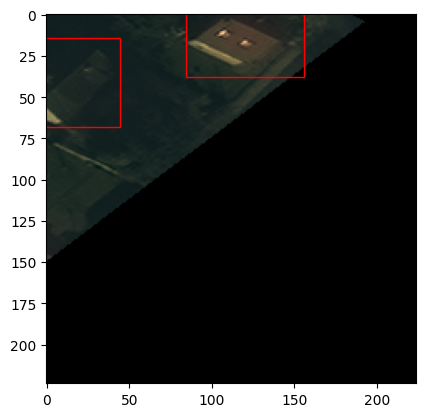

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from rasterio.plot import show

def read_yolo_labels(label_file_path):
    with open(label_file_path, 'r') as label_file:
        lines = label_file.readlines()
    return [line.strip().split() for line in lines]

def plot_image_with_bboxes(image_path, label_file_path):
    # Read image
    with rasterio.open(image_path) as src:
        image = src.read()

    fig, ax = plt.subplots()

    # Show the image
    show(image, ax=ax)

    # Read YOLO format labels
    labels = read_yolo_labels(label_file_path)

    # Add bounding boxes to the ax
    for label in labels:
        class_id = int(label[0])
        x_center = float(label[1])
        y_center = float(label[2])
        width = float(label[3])
        height = float(label[4])

        img_height, img_width = image.shape[1], image.shape[2]

        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Show image with bounding boxes
    plt.show()

image_path = "dataset_YOLO/RGB/full_Dataset_background_split/images/train/AOI_3_Paris_img1906_x224_y224.png"
label_path = "dataset_YOLO/RGB/full_Dataset_background_split/labels/train/AOI_3_Paris_img1906_x224_y224.txt"

plot_image_with_bboxes(image_path, label_path)


# Choose the best 3 channels from MUL

In [ ]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from itertools import combinations

# Path to your folder containing the TIFF images
folder_path = 'MUL-PanSharpen'

# Get a list of all TIFF image filenames in the folder
image_filenames = [filename for filename in os.listdir(folder_path) if filename.endswith('.tif')]

# Initialize arrays to store channel data and labels
num_channels = 8  # Assuming 8 channels
channel_data = np.zeros((len(image_filenames), num_channels))
labels = np.random.randint(2, size=len(image_filenames))  # Example labels (0 or 1)

# Read channel data and calculate scores for each channel
for i, filename in enumerate(image_filenames):
    with rasterio.open(os.path.join(folder_path, filename)) as src:
        for channel in range(src.count):  # Loop through channels
            channel_data[i, channel] = np.mean(src.read(channel + 1))

# Define the scoring functions for cross-validation
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score)
}

# Create all possible combinations of 3 channels from 8
combinations_3_channels = list(combinations(range(num_channels), 3))

# Initialize a list to store results
results = []

# Iterate through each channel combination and perform cross-validation
for combo in combinations_3_channels:
    selected_channels = channel_data[:, combo]
    model = LogisticRegression()  # Example classifier, replace with your own
    
    # Perform cross-validation using multiple scoring metrics
    scores = cross_validate(model, selected_channels, labels, cv=5, scoring=scoring)
    
    # Extract F1-score and AUC scores from the cross-validation results
    f1_scores = scores['test_f1_macro']
    auc_scores = scores['test_roc_auc']
    
    # Compute mean scores
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores)
    
    results.append((combo, mean_f1, mean_auc))

# Sort results by average F1-score in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Print the top 3 channel combinations and their scores
print("Top 3 Channel Combinations based on F1-Score:")
for i, (combo, f1, auc) in enumerate(results[:3]):
    print(f"{i+1}. Channels: {combo}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")


# Create 3 channels images folders

In [17]:
import os
import rasterio
import numpy as np

input_folder = r"dataset_YOLO\MUL_650\images\test"
output_folder = r"dataset_YOLO\custom_650\images\test"
selected_channels = [1,2,5]  

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_folder, filename)
        output_filename = os.path.splitext(filename)[0] + ".png"
        output_path = os.path.join(output_folder, output_filename)

        with rasterio.open(input_path) as src:
            # Read the selected channels
            selected_channels_data = src.read(selected_channels)

            # Normalize the data to 0-255 range (for PNG)
            min_val = selected_channels_data.min()
            max_val = selected_channels_data.max()
            normalized_data = ((selected_channels_data - min_val) * 255.0 / (max_val - min_val)).astype(np.uint8)

            # Create a new image with the selected channels
            profile = src.profile
            profile.update(count=len(selected_channels), dtype=np.uint8)

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(normalized_data)


print("Processing completed.")


Processing completed.


In [ ]:
import tensorflow as tf
import numpy as np
import os
import rasterio

# Function to preprocess the image for the VGG16 model
def preprocess_image(image):
    # Resize the image to the VGG16 input size (224x224)
    resized_image = tf.image.resize(image, (224, 224))
    
    # Normalize the image according to VGG16's preprocessing
    normalized_image = tf.keras.applications.vgg16.preprocess_input(resized_image)
    
    return normalized_image

# Function to calculate channel importance using the VGG16 model
def calculate_channel_importance(image, model):
    # Preprocess the image for the model
    preprocessed_image = image
    
    # Get the feature maps from a specific layer of the model
    layer_name = "block5_conv3"  # Choose a layer in the VGG16 model
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = intermediate_layer_model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Calculate the importance of each channel in the feature maps
    channel_importance_scores = np.mean(feature_maps, axis=(1, 2, 3))

    return channel_importance_scores

# Load the pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Folder containing TIFF images
folder_path = "path/to/your/tiff/images"

# Initialize an array to store channel importance scores
channel_importance_scores = np.zeros(8)

# Iterate through the TIFF images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        # Load the TIFF image using rasterio
        with rasterio.open(os.path.join(folder_path, filename)) as src:
            # Read all the channels from the image
            image = src.read()

        # Calculate importance scores for each channel in the image
        importance_scores = calculate_channel_importance(image, model)

        # Add the importance scores to the aggregate scores
        channel_importance_scores += importance_scores

# Rank the channels based on their aggregate importance scores
ranked_channels = np.argsort(channel_importance_scores)[::-1]

# Select the top 3 channels
average_best_3_channels = ranked_channels[:3]

print("Average Best 3 Channels:", average_best_3_channels)


In [1]:
import pandas as pd
from shapely.geometry import Polygon
from shapely.wkt import loads

def polygon_to_pascal_voc(row):
    polygon = loads(row['PolygonWKT_Geo'])
    min_x, min_y, max_x, max_y = polygon.bounds
    return {
        'xmin': min_x,
        'ymin': min_y,
        'xmax': max_x,
        'ymax': max_y,
    }

# Replace 'df' with your DataFrame name
df = pd.read_csv('summaryData/AOI_3_Paris_Train_Building_Solutions.csv')  # Load your DataFrame from a CSV file

# Apply the function to create Pascal VOC bounding boxes
df['bbox'] = df.apply(polygon_to_pascal_voc, axis=1)

# Split the 'bbox' dictionary into separate columns
df[['xmin', 'ymin', 'xmax', 'ymax']] = df['bbox'].apply(pd.Series)

# Drop the 'bbox' column if you no longer need it
df.drop(columns=['bbox'], inplace=True)

# Create a new DataFrame in Pascal VOC format
pascal_voc_df = df[['ImageId', 'xmin', 'ymin', 'xmax', 'ymax']]

# Save the Pascal VOC DataFrame to a CSV file or use it for training
pascal_voc_df.to_csv('pascal_voc_annotations.csv', index=False)


In [3]:
import os
import json

# Specify the folder paths for images and polygons coordinates
image_folder = r"D:\AOI_3_Paris_Train\RGB-Prepro"
polygon_folder = r"D:\AOI_3_Paris_Train\geojson\buildings"

# Initialize an empty list to store the features
features = []

# Iterate through the image files
for image_filename in os.listdir(image_folder):
    # Get the corresponding polygon file
    polygon_filename = os.path.join(polygon_folder, f"buildings_{image_filename.replace('_img', '')}.geojson")
    
    # Check if the polygon file exists
    if os.path.isfile(polygon_filename):
        # Read the JSON content from the polygon file
        with open(polygon_filename, "r") as polygon_file:
            polygon_data = json.load(polygon_file)
        
        # Extract bounding box coordinates from the polygon data
        # Assuming your polygon data has a structure similar to your provided example
        coordinates = polygon_data["features"][0]["geometry"]["coordinates"][0]
        x_coords, y_coords = zip(*coordinates)
        min_x, max_x, min_y, max_y = min(x_coords), max(x_coords), min(y_coords), max(y_coords)
        
        # Create a bounding box feature
        feature = {
            "type": "Feature",
            "properties": {
                "min_x": min_x,
                "max_x": max_x,
                "min_y": min_y,
                "max_y": max_y
            }
        }
        
        features.append(feature)
    else:
        # Create an empty feature for unlabeled images
        feature = {
            "type": "Feature",
            "properties": {
                "min_x": None,
                "max_x": None,
                "min_y": None,
                "max_y": None
            }
        }
        
        features.append(feature)

    # Create the final FeatureCollection
    feature_collection = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
            }
        },
        "features": features
    }

# Save the FeatureCollection as a JSON file
with open("output_bbox.json", "w") as output_file:
    json.dump(feature_collection, output_file, indent=2)


# Create xml annotations folder

In [20]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import re

# Assuming your DataFrame is already loaded, let's call it 'df'
df = pd.read_csv("")
# Create the 'annotations' folder if it doesn't exist
annotations_folder = 'annotations'
if not os.path.exists(annotations_folder):
    os.makedirs(annotations_folder)

# Iterate through unique image IDs
for image_id in df['ImageId'].unique():
    # Create a new annotation for each image
    annotation = ET.Element('annotation')

    # Create and append child elements to the annotation
    folder = ET.SubElement(annotation, 'folder')
    folder.text = 'images'

    filename = ET.SubElement(annotation, 'filename')
    filename.text = f"{image_id}.png"  # Assuming your image filenames match the ImageId

    size = ET.SubElement(annotation, 'size')
    width = ET.SubElement(size, 'width')
    width.text = '650'  # Set the image width (650 in this case)

    height = ET.SubElement(size, 'height')
    height.text = '650'  # Set the image height (650 in this case)

    depth = ET.SubElement(size, 'depth')
    depth.text = '3'  # Set the image depth (3 in this case)

    segmented = ET.SubElement(annotation, 'segmented')
    segmented.text = '0'

    # Filter the DataFrame for the current image_id
    image_df = df[df['ImageId'] == image_id]

    # Initialize a flag to check if any valid bounding box was found for this image
    valid_bbox_found = False

    # Iterate through the rows for the current image_id
    for _, row in image_df.iterrows():
        # Extract bounding box coordinates from PolygonWKT_Pix
        polygon_wkt_pix = row['PolygonWKT_Pix']
        polygon_wkt_pix = polygon_wkt_pix.replace('EMPT', '').strip()

        if not polygon_wkt_pix or 'POLYGON ((' not in polygon_wkt_pix:
            continue  # Skip rows with invalid polygons

        polygons = polygon_wkt_pix.split('),(')
        x_coords = []
        y_coords = []

        for polygon in polygons:
            polygon_list = polygon.strip('POLYGON ((').strip('))').split(',')
            x_coords += [float(point.split()[0]) for point in polygon_list]
            y_coords += [float(point.split()[1]) for point in polygon_list]

        # Calculate the 'Width' and 'Height' based on bounding box coordinates
        min_x = int(min(x_coords))
        max_x = int(max(x_coords))
        min_y = int(min(y_coords))
        max_y = int(max(y_coords))
        box_width = max_x - min_x
        box_height = max_y - min_y

        # Check if the bounding box has a valid width and height
        if box_width > 0 and box_height > 0:
            bndbox = ET.SubElement(annotation, 'bndbox')

            xmin_elem = ET.SubElement(bndbox, 'xmin')
            xmin_elem.text = str(min_x)

            ymin_elem = ET.SubElement(bndbox, 'ymin')
            ymin_elem.text = str(min_y)

            xmax_elem = ET.SubElement(bndbox, 'xmax')
            xmax_elem.text = str(max_x)

            ymax_elem = ET.SubElement(bndbox, 'ymax')
            ymax_elem.text = str(max_y)

            # Set the flag to indicate that a valid bounding box was found
            valid_bbox_found = True

    # Check if a valid bounding box was found for this image
    if valid_bbox_found:
        # Create an ElementTree object from the annotation
        tree = ET.ElementTree(annotation)

        # Save the annotation as an XML file
        xml_filename = os.path.join(annotations_folder, f"{image_id}.xml")
        tree.write(xml_filename)
